In [1]:
import torch  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print(device)

cuda


In [3]:
import pandas as pd  
import numpy as np  
import torch.nn as nn  
from sklearn.preprocessing import MinMaxScaler  
from sklearn.metrics import r2_score 
  
# Load and preprocess data    
df = pd.read_csv('resampled_cpu_usage_per_machine.csv')    
df['start_time'] = pd.to_datetime(df['start_time'])    
df.set_index('start_time', inplace=True)    
  
# Select first 10 machines    
machines = df['machine_id'].unique()[:10]  
df = df[df['machine_id'].isin(machines)]  
df = df[['machine_id', 'maximum_cpu_usage']]    
  
# Scale data to (0, 1) for LSTM    
scaler = MinMaxScaler(feature_range=(0, 1))    
df['maximum_cpu_usage'] = scaler.fit_transform(df['maximum_cpu_usage'].values.reshape(-1,1))    
  
# Convert DataFrame to numpy array    
data = {machine: df[df['machine_id'] == machine]['maximum_cpu_usage'].values for machine in machines}   
  
# Split data into train and test sets    
seq_length_in = 144  
seq_length_out = 6  
train_data = {}  
test_data = {}  
for machine in machines:  
    machine_data = data[machine]  
    train_size = int(len(machine_data) * 0.80)    
    train_data[machine], test_data[machine] = machine_data[:train_size], machine_data[train_size:]   
  
# Create sequences    
def create_sequences(input_data, seq_length_in, seq_length_out):    
    inout_seq = []    
    L = len(input_data)    
    for i in range(L-seq_length_in-seq_length_out):    
        train_seq = torch.FloatTensor(input_data[i:i+seq_length_in])  
        train_label = torch.FloatTensor(input_data[i+seq_length_in:i+seq_length_in+seq_length_out])   
        inout_seq.append((train_seq ,train_label))    
    return inout_seq    
  
train_inout_seq = {machine: create_sequences(machine_data, seq_length_in, seq_length_out) for machine, machine_data in train_data.items()}   
  
# Create DataLoader for mini-batches, take 64 each time  
batch_size = 512  
train_data_loader = {machine: torch.utils.data.DataLoader(machine_inout_seq, batch_size=batch_size, shuffle=True) for machine, machine_inout_seq in train_inout_seq.items()}    
  
# Define LSTM model  
class LSTM(nn.Module):  
    def __init__(self, input_size, hidden_size, num_layers, output_size):  
        super(LSTM, self).__init__()  
        self.hidden_size = hidden_size  
        self.num_layers = num_layers  
  
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  
        self.fc = nn.Linear(hidden_size, output_size)  
  
    def forward(self, x):  
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  
  
        out, _ = self.lstm(x, (h_0, c_0))  
        out = self.fc(out[:, -1, :])  
  
        return out  
  
# Set up LSTM model parameters
num_epochs = 2000
learning_rate = 0.01  
input_size = 1  
hidden_size = 100
num_layers = 1
output_size = seq_length_out
  
lstm = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
  
# Set loss function and optimizer  
criterion = torch.nn.MSELoss()    # mean-squared error for regression  
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)   
  
# Train model  
lstm.train()
for epoch in range(num_epochs):   
    sample_num = 0
    squared_error_sum = 0
    
    for machine_id, data_loader in train_data_loader.items():  
        for i, (seq, labels) in enumerate(data_loader):   
            seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)  
            labels = torch.FloatTensor(labels).view(-1, seq_length_out).to(device)  
  
            optimizer.zero_grad()    
            y_pred = lstm(seq)    
  
            single_loss = criterion(y_pred, labels)    
            squared_error_sum += single_loss.item() * seq.size(0)  # Multiply by batch size  
            sample_num += seq.size(0)  
            single_loss.backward()    
            optimizer.step()    
  
    if (epoch+1)%100 == 0:  
        train_mse = squared_error_sum / sample_num  
        train_rmse = np.sqrt(train_mse)
        print('epoch: ', epoch+1, 'train RMSE: ', train_rmse, 'train MSE: ', train_mse, 'loss: ', single_loss.item())     

torch.save(lstm.state_dict(), './predict_service/models/6_LSTM_seq2seq_multiple_machine_miniSGD-.pth')  
# Test model  
lstm.eval()  
test_inout_seq = {machine: create_sequences(machine_data, seq_length_in, seq_length_out) for machine, machine_data in test_data.items()}  
test_rmse = 0  
test_mse = 0  
ttl = 0  
predictions = []    
actuals = []   
with torch.no_grad():  
    for machine_id, seqs in test_inout_seq.items():  
        for seq, labels in seqs:    
            seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)    
            labels = torch.FloatTensor(labels).view(-1, seq_length_out).to(device)    
            y_test_pred = lstm(seq)    
  
            # Ensure labels and y_test_pred have the same size    
            if y_test_pred.shape != labels.shape:    
                print("Shape mismatch: y_test_pred has shape {} but labels have shape {}".format(y_test_pred.shape, labels.shape))    
                continue    
  
            predictions.append(y_test_pred.cpu().detach().numpy())    
            actuals.append(labels.cpu().detach().numpy())    
  
            test_loss = criterion(y_test_pred, labels)   
            test_rmse += np.sqrt(test_loss.item())  
            test_mse += np.mean(test_loss.item())  
            ttl += 1  
  
# Flatten the lists of predictions and actuals into 1D arrays    
predictions = np.concatenate(predictions).ravel()    
actuals = np.concatenate(actuals).ravel()    
  
r2 = r2_score(actuals, predictions)    
  
print('test RMSE: ', test_rmse/ttl, 'test MSE: ', test_mse/ttl, 'r2-score: ', r2)  


epoch:  100 train RMSE:  0.03108396705281915 train MSE:  0.0009662130077407465 loss:  0.0010755568509921432
epoch:  200 train RMSE:  0.030810380790354856 train MSE:  0.0009492795644466675 loss:  0.001214866410009563
epoch:  300 train RMSE:  0.03691710039984502 train MSE:  0.0013628723019322375 loss:  0.0013686339370906353
epoch:  400 train RMSE:  0.03522331549917477 train MSE:  0.0012406819547544055 loss:  0.0013949297135695815
epoch:  500 train RMSE:  0.03581462893172568 train MSE:  0.001282687645517202 loss:  0.0011650380911305547
epoch:  600 train RMSE:  0.03427484782488809 train MSE:  0.001174765193419236 loss:  0.0014721144689247012
epoch:  700 train RMSE:  0.038215995218098604 train MSE:  0.0014604622905097352 loss:  0.0016887403326109052
epoch:  800 train RMSE:  0.03234448701912286 train MSE:  0.0010461658405302074 loss:  0.0012869656784459949
epoch:  900 train RMSE:  0.030975151830648237 train MSE:  0.0009594600309317108 loss:  0.0012519187293946743
epoch:  1000 train RMSE:  0.

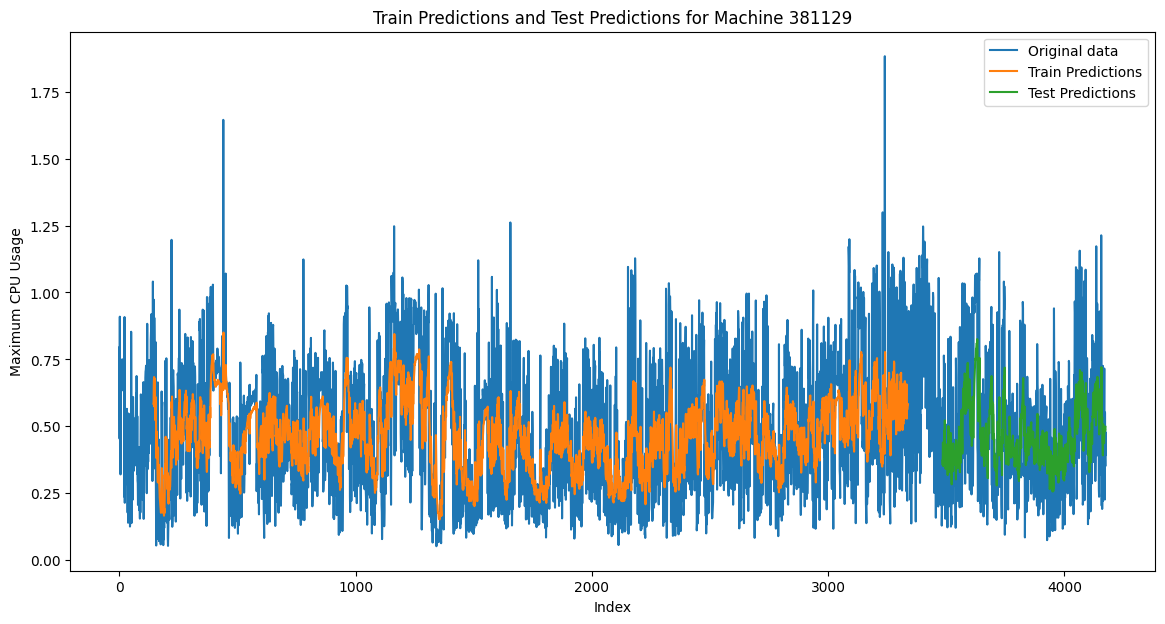

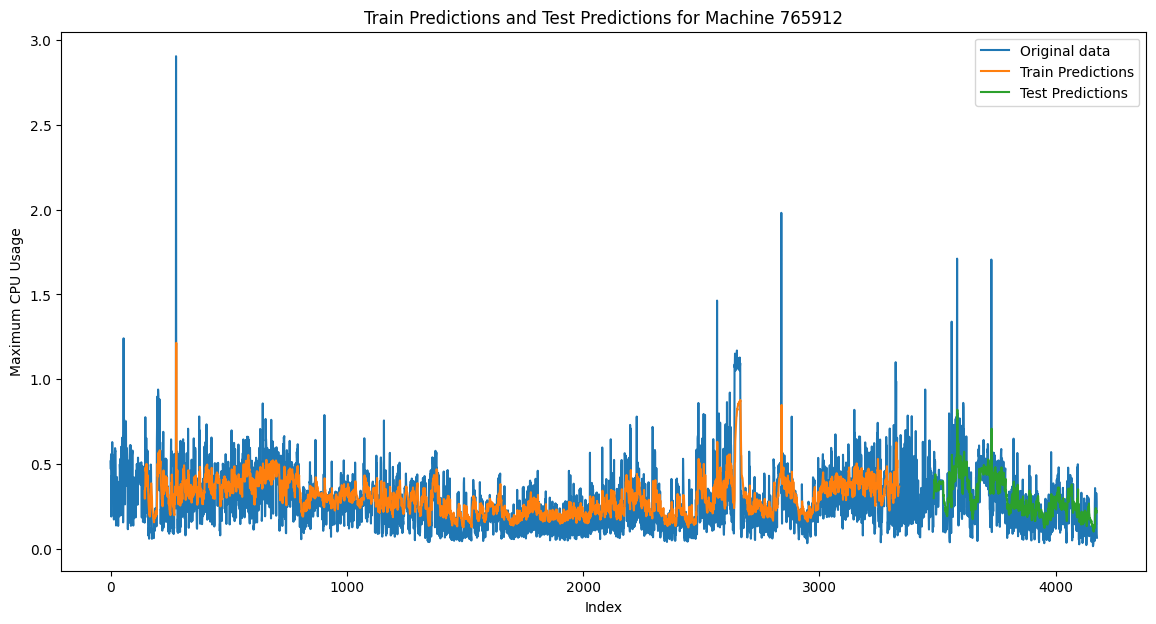

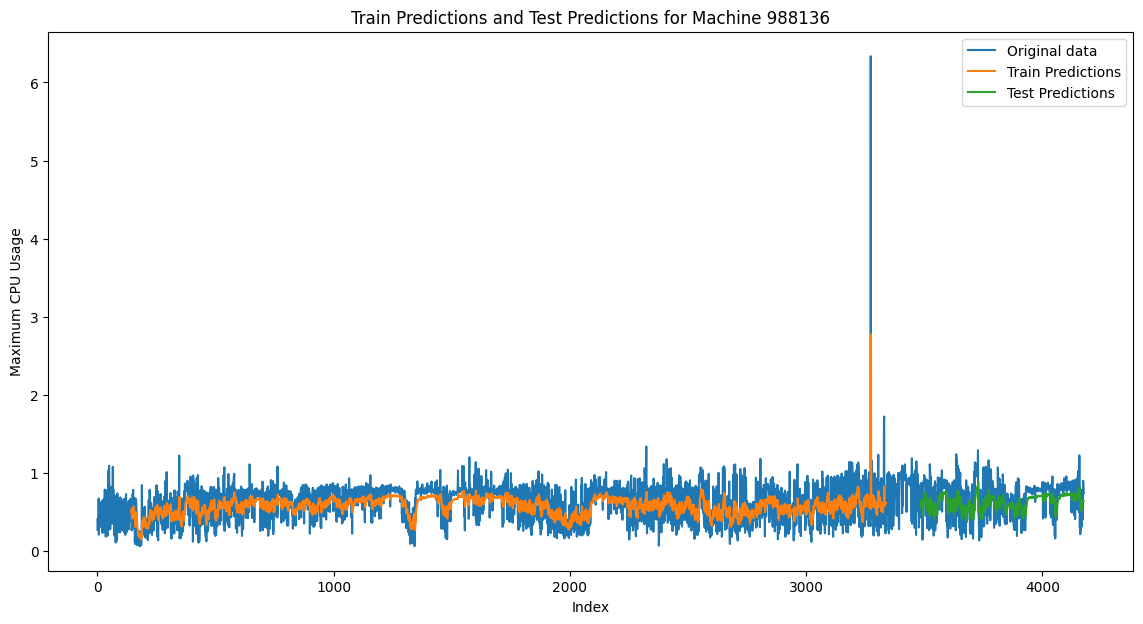

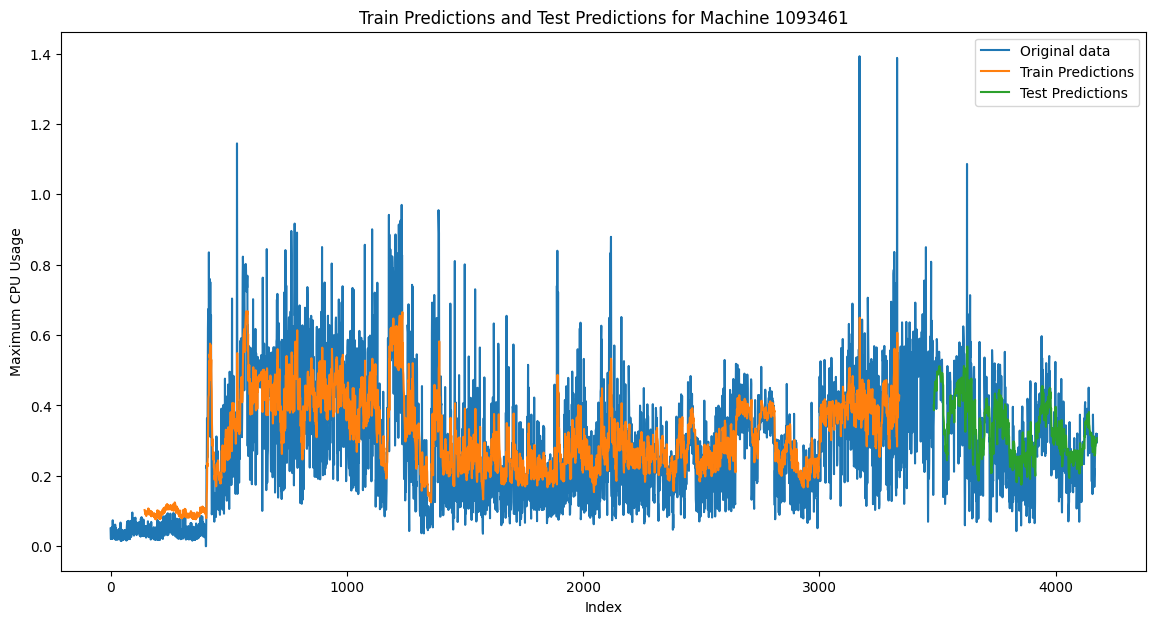

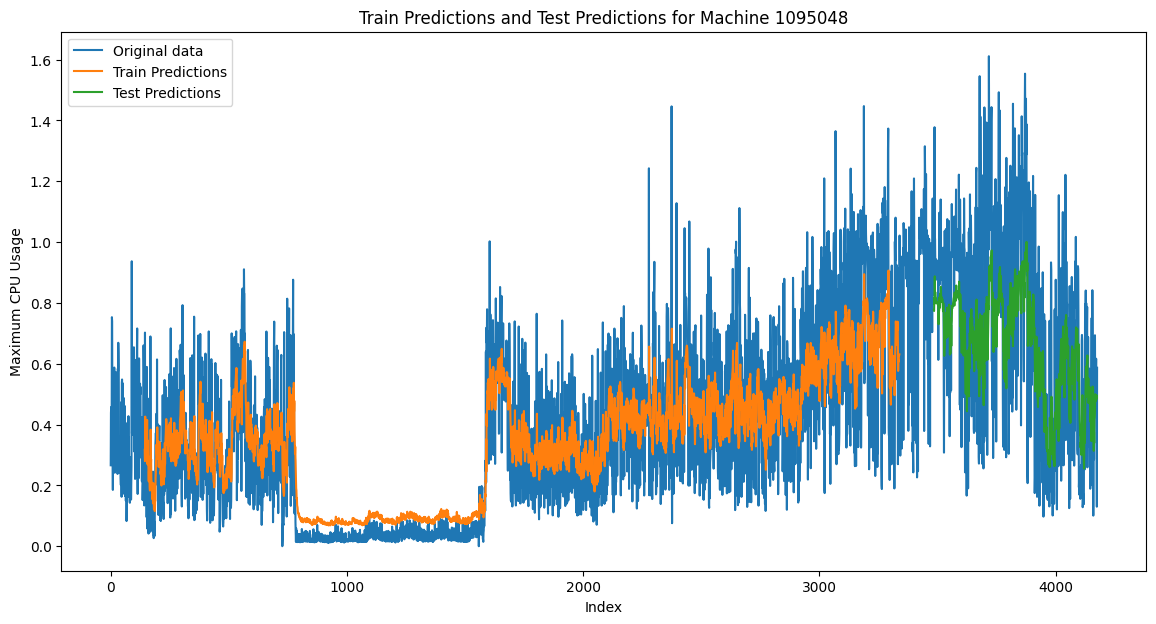

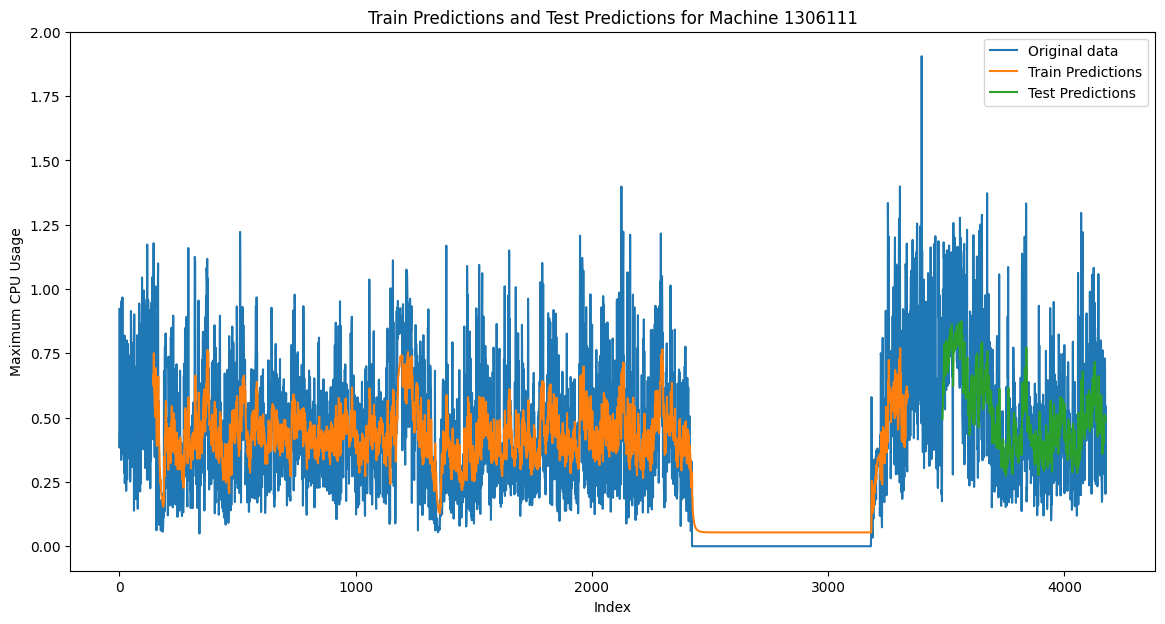

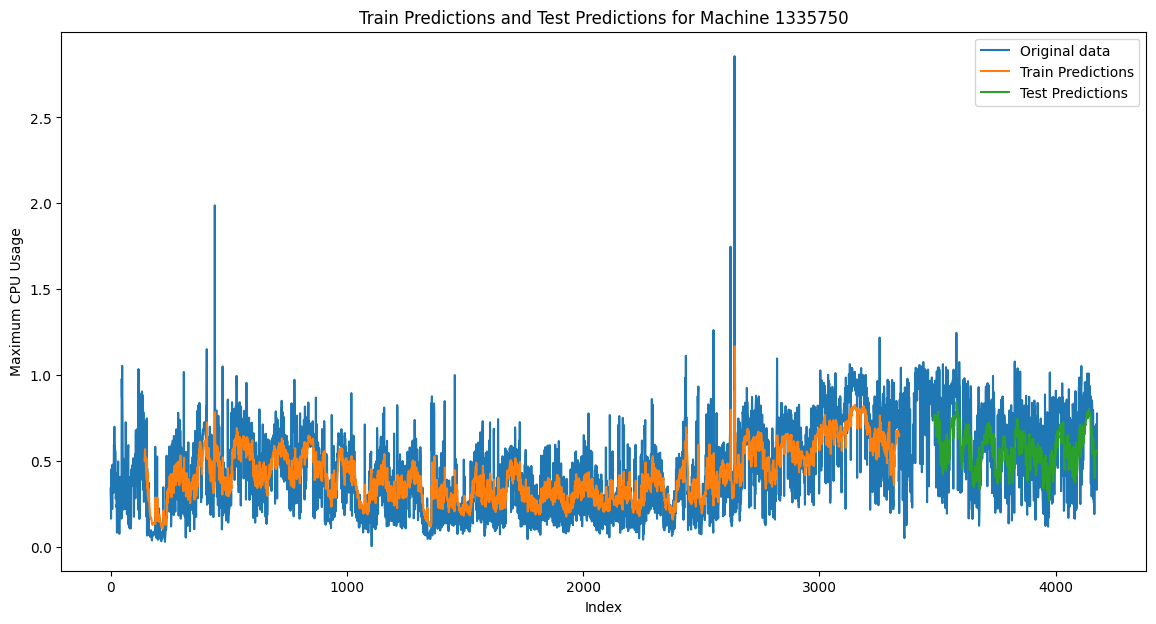

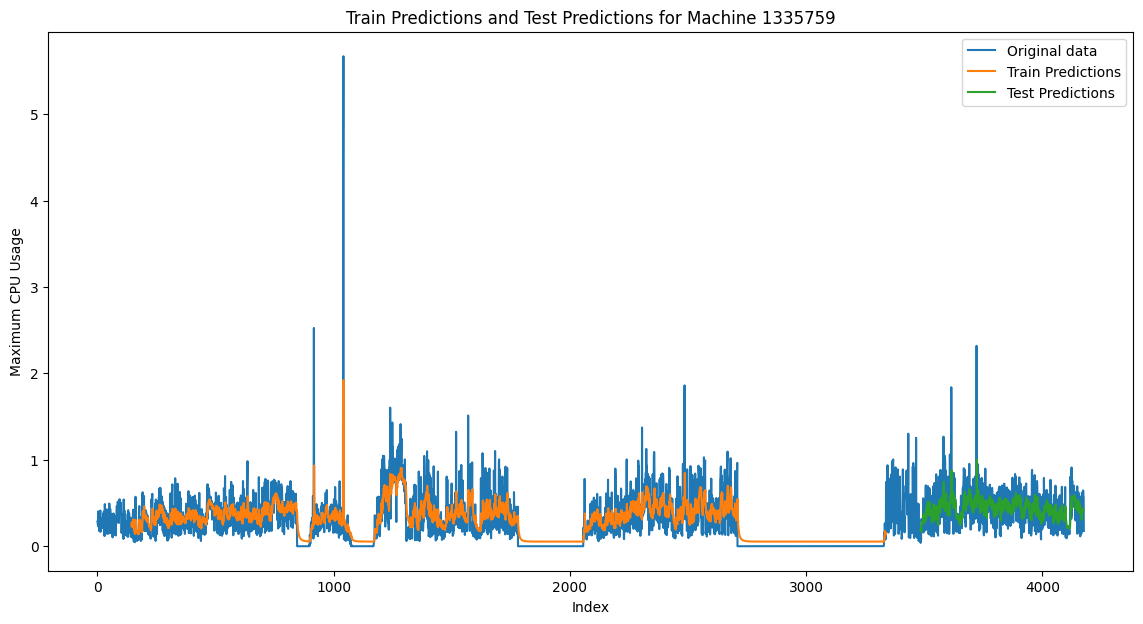

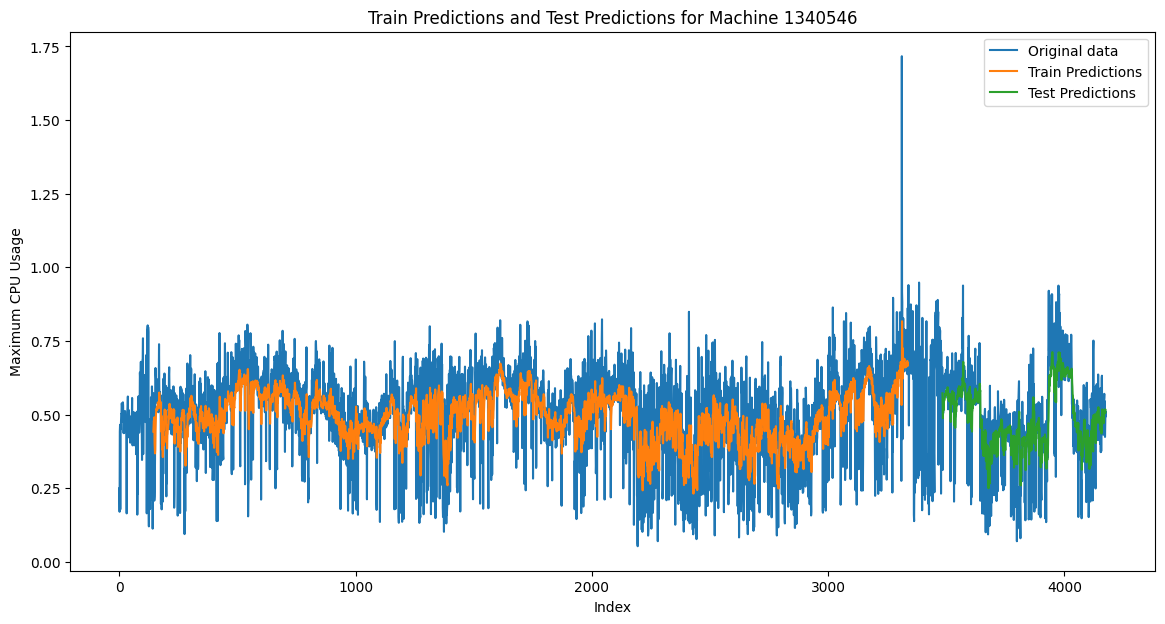

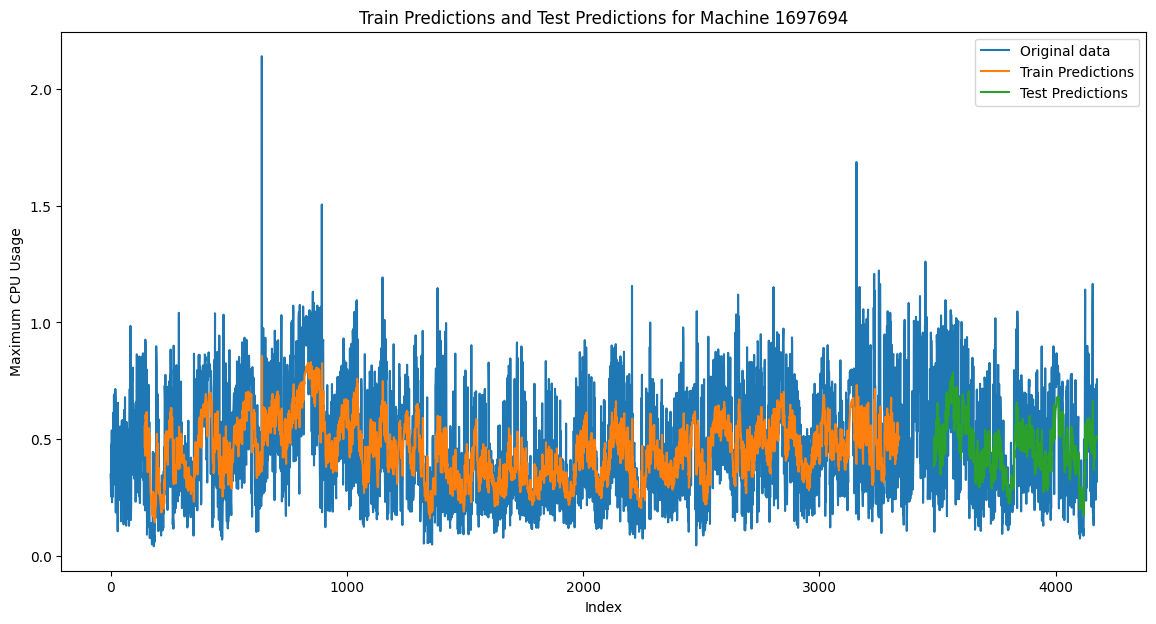

In [14]:
import matplotlib.pyplot as plt   
  
for machine_id in machines:  
    # Create empty arrays of NaNs  
    train_predictions = np.empty_like(train_data[machine_id])  
    train_predictions[:] = np.nan  
    test_predictions = np.empty_like(test_data[machine_id])  
    test_predictions[:] = np.nan  
  
    # Generate predictions  
    lstm.eval()  
    with torch.no_grad():    
        for i, (seq, labels) in enumerate(train_inout_seq[machine_id]):    
            seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)    
            train_pred = lstm(seq)    
            train_predictions[i+seq_length_in : i+seq_length_in+seq_length_out] = train_pred.cpu().numpy().flatten()    
  
        for i, (seq, labels) in enumerate(test_inout_seq[machine_id]):    
            seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)    
            test_pred = lstm(seq)    
            test_predictions[i+seq_length_in : i+seq_length_in+seq_length_out] = test_pred.cpu().numpy().flatten()    
  
    train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))    
    test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))    
    data = scaler.inverse_transform(np.concatenate((train_data[machine_id], test_data[machine_id])).reshape(-1, 1))    
  
    # Plotting    
    plt.figure(figsize=(14, 7))    
  
    # Original data    
    plt.plot(range(len(data)), data, label='Original data')    
  
    # Train predictions    
    plt.plot(range(len(train_predictions)), train_predictions, label='Train Predictions')    
  
    # Test predictions    
    plt.plot(range(len(data) - len(test_predictions), len(data)), test_predictions, label='Test Predictions')    
  
    plt.title(f'Train Predictions and Test Predictions for Machine {machine_id}')    
    plt.xlabel('Index')    
    plt.ylabel('Maximum CPU Usage')    
    plt.legend()    
    plt.show()    


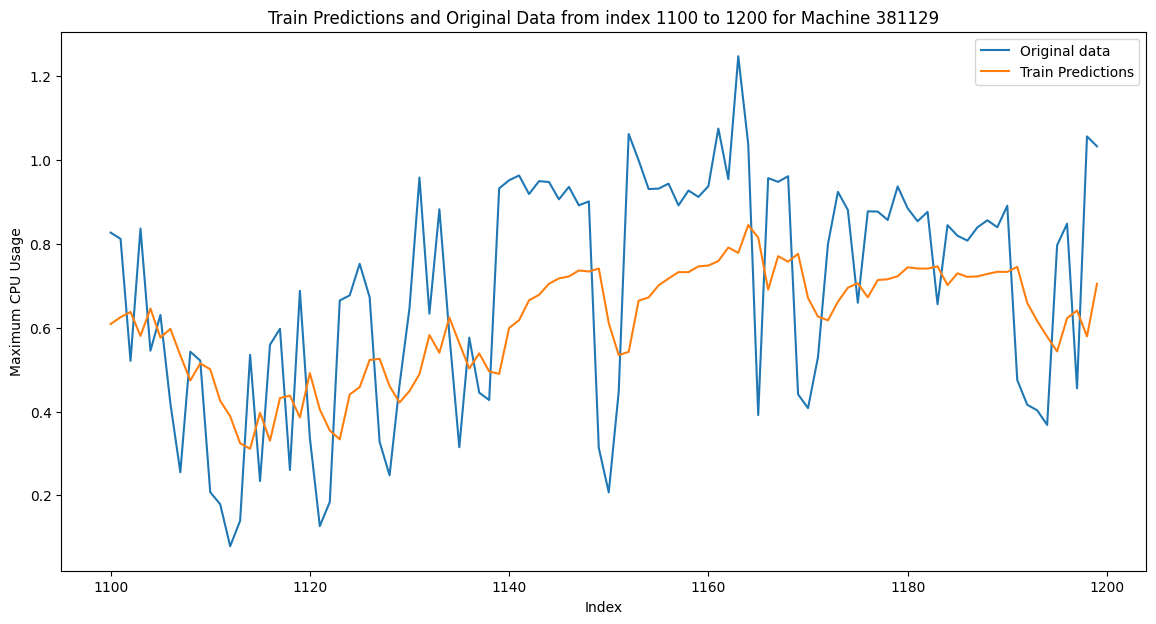

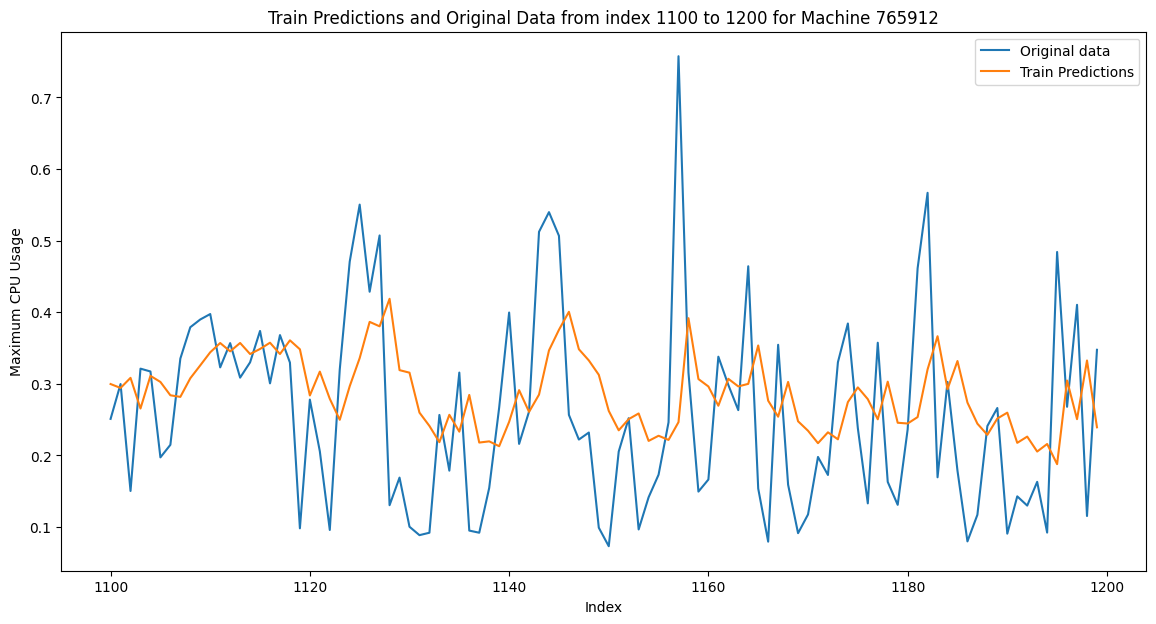

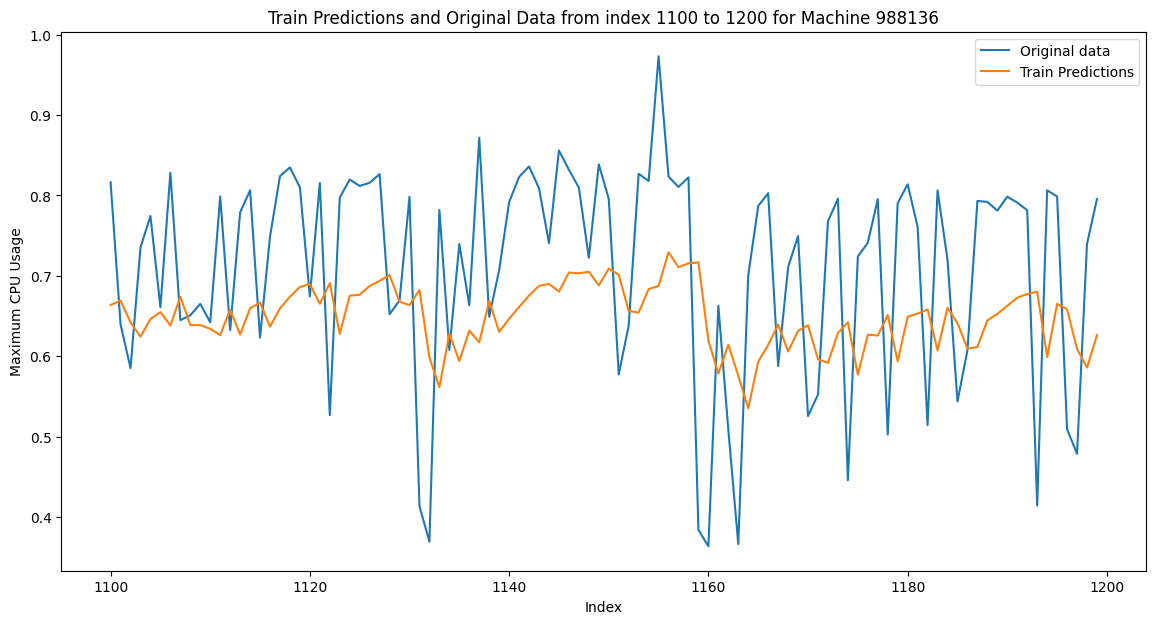

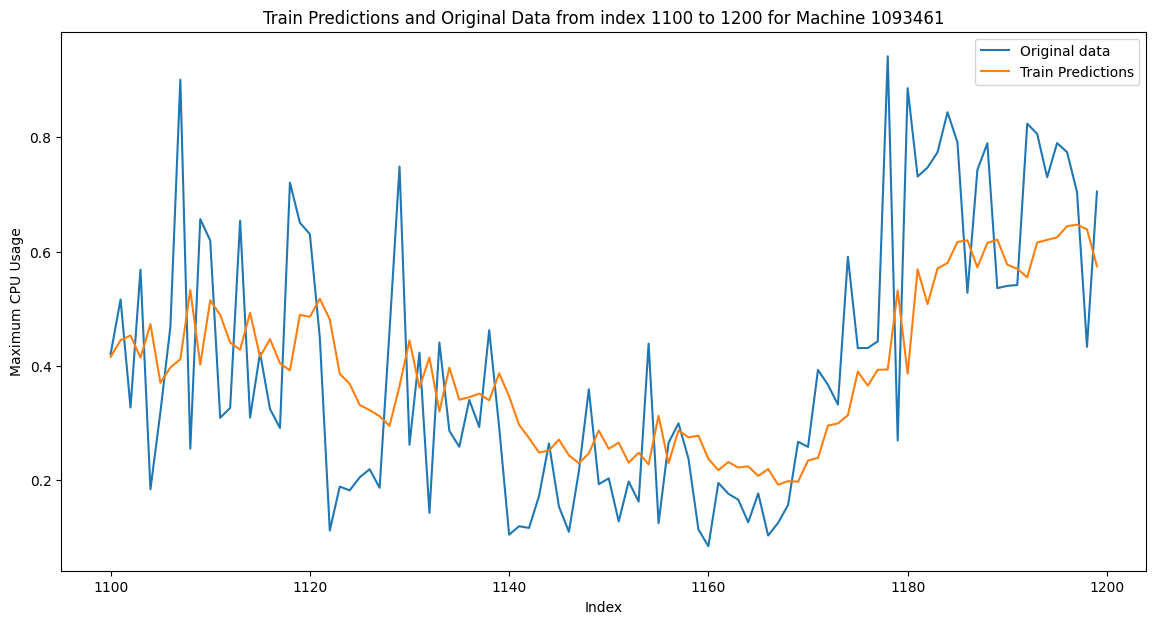

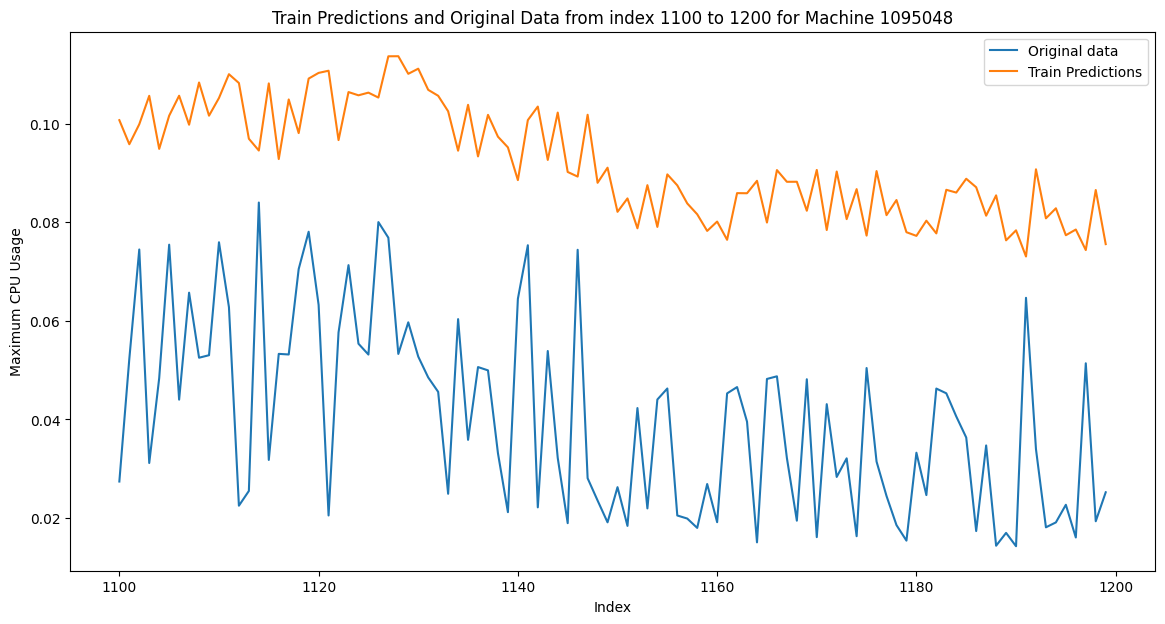

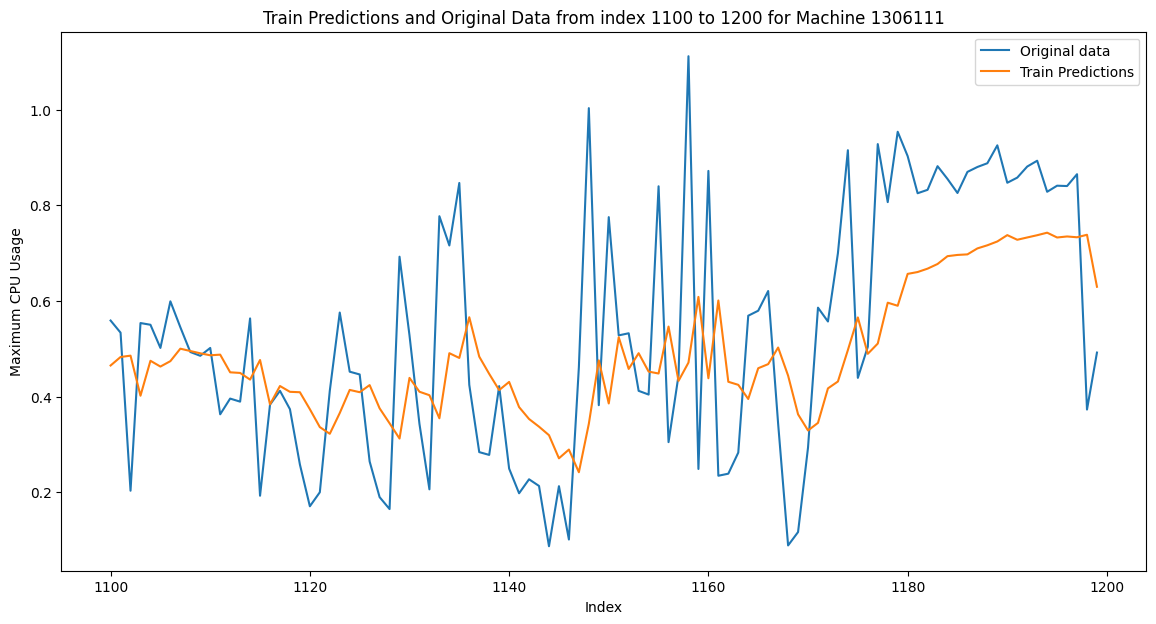

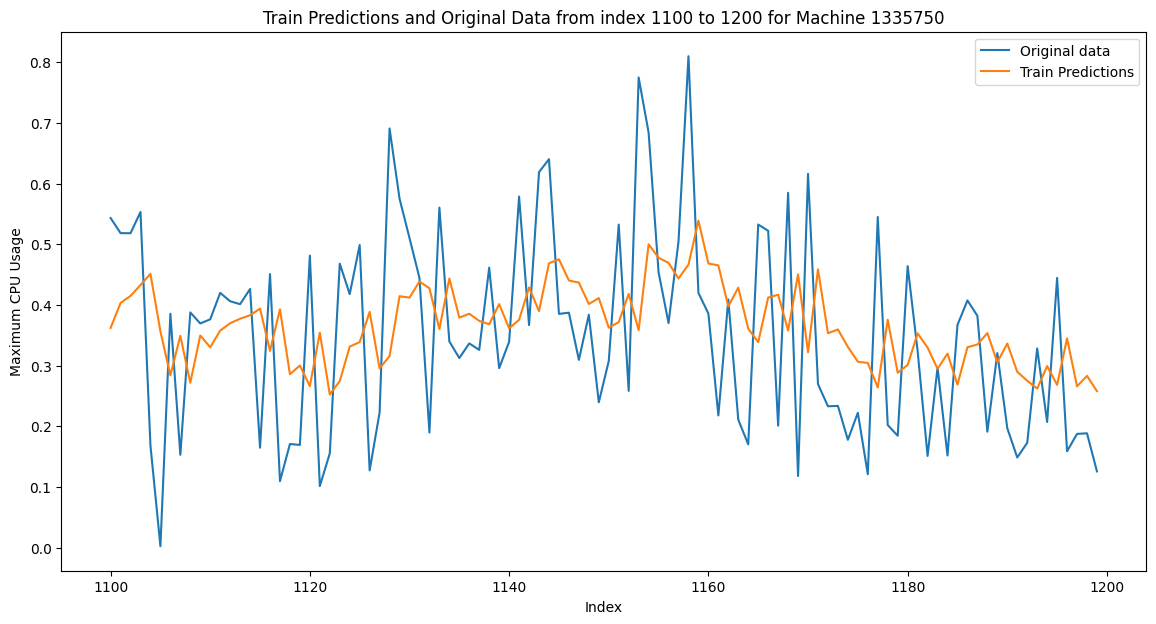

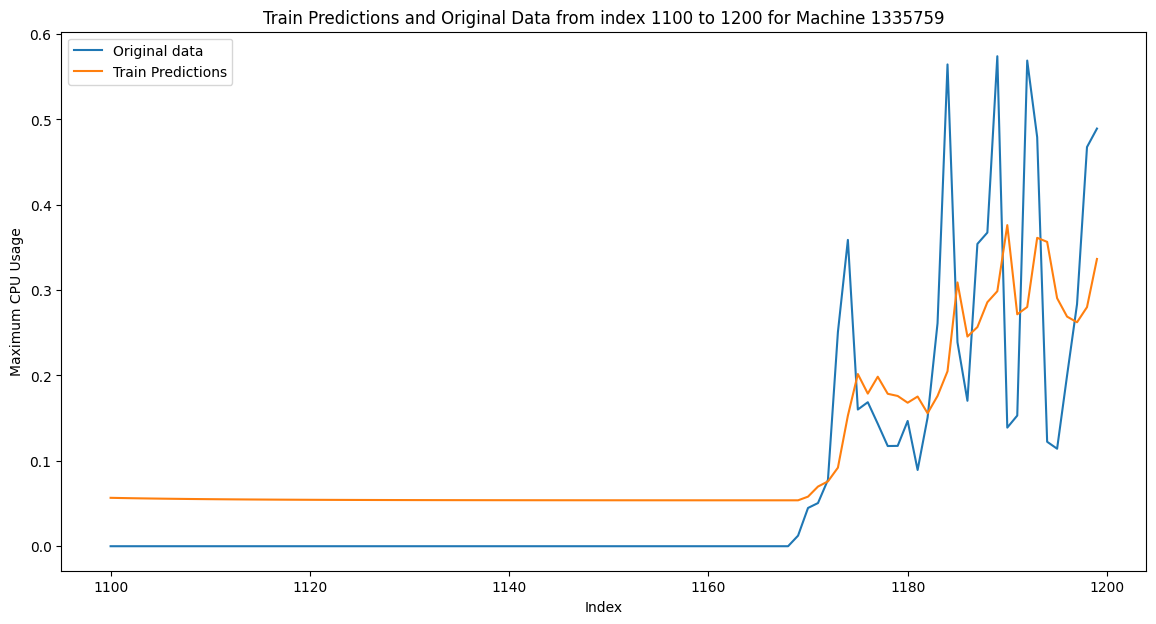

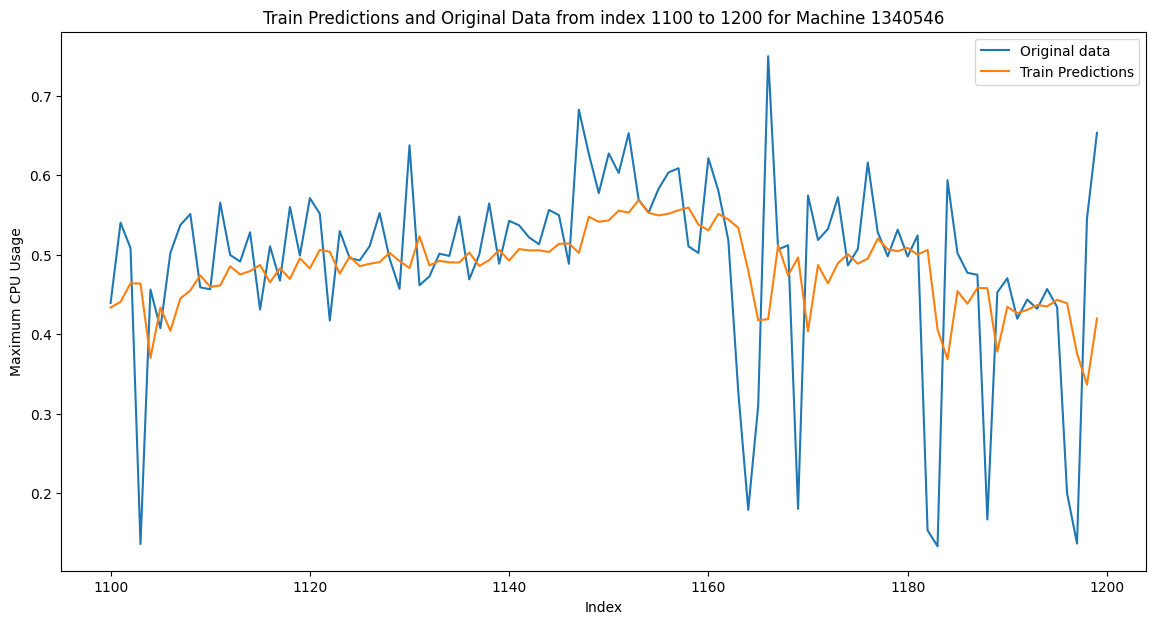

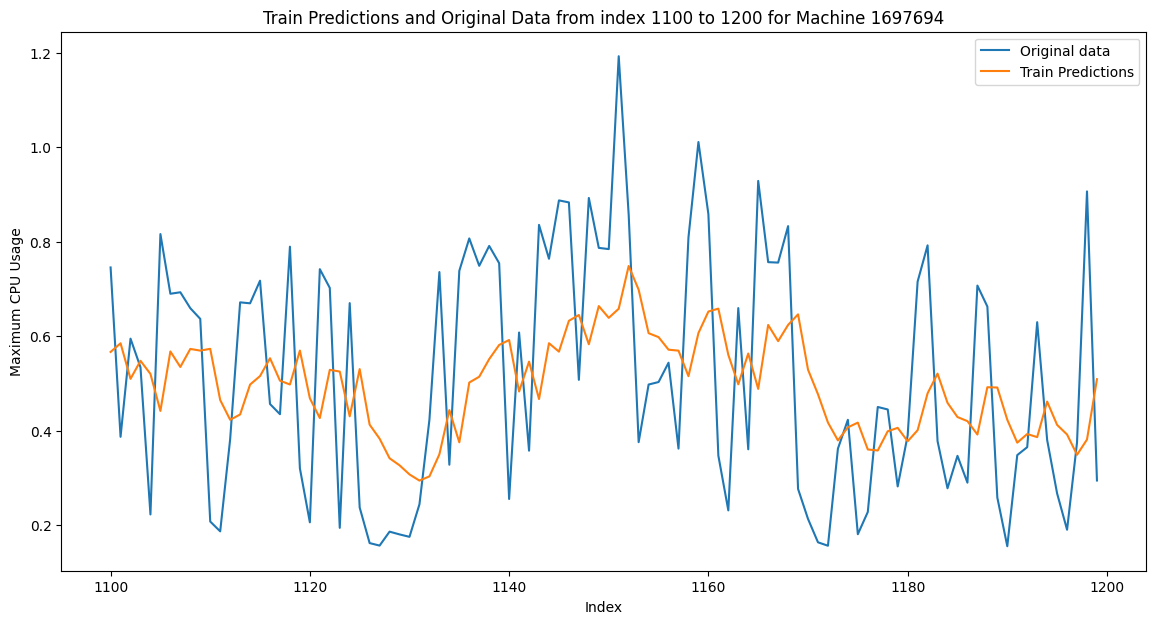

In [15]:
# Define the range of interest    
start_index = 1100    
end_index = 1200    
  
for machine_id in machines:  
    # Create empty arrays of NaNs  
    train_predictions = np.empty_like(train_data[machine_id])  
    train_predictions[:] = np.nan  
    test_predictions = np.empty_like(test_data[machine_id])  
    test_predictions[:] = np.nan  
  
    # Generate predictions  
    lstm.eval()  
    with torch.no_grad():    
        for i, (seq, labels) in enumerate(train_inout_seq[machine_id]):    
            seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)    
            train_pred = lstm(seq)    
            train_predictions[i+seq_length_in : i+seq_length_in+seq_length_out] = train_pred.cpu().numpy().flatten()    
  
        for i, (seq, labels) in enumerate(test_inout_seq[machine_id]):    
            seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)    
            test_pred = lstm(seq)    
            test_predictions[i+seq_length_in : i+seq_length_in+seq_length_out] = test_pred.cpu().numpy().flatten()    
  
    train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))    
    test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))    
    data = scaler.inverse_transform(np.concatenate((train_data[machine_id], test_data[machine_id])).reshape(-1, 1))    
  
    # Plotting    
    plt.figure(figsize=(14, 7))    
  
    # Original data    
    plt.plot(range(start_index, end_index), data[start_index:end_index], label='Original data')    
  
    # Train predictions    
    plt.plot(range(start_index, end_index), train_predictions[start_index:end_index], label='Train Predictions')    
  
    plt.title(f'Train Predictions and Original Data from index {start_index} to {end_index} for Machine {machine_id}')    
    plt.xlabel('Index')    
    plt.ylabel('Maximum CPU Usage')    
    plt.legend()    
    plt.show()    


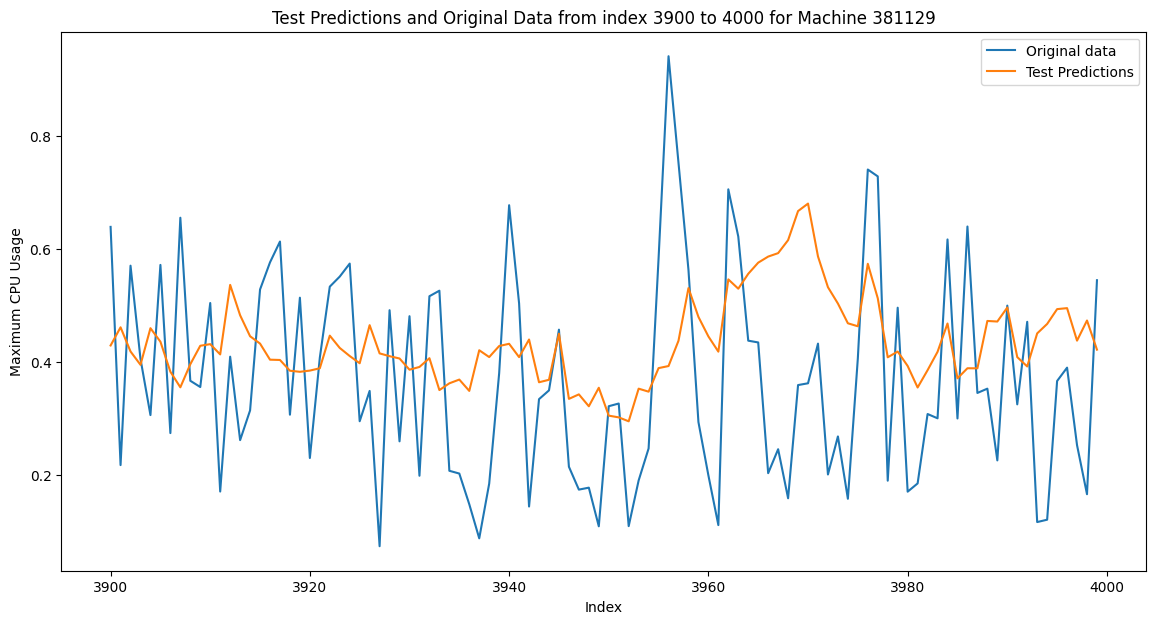

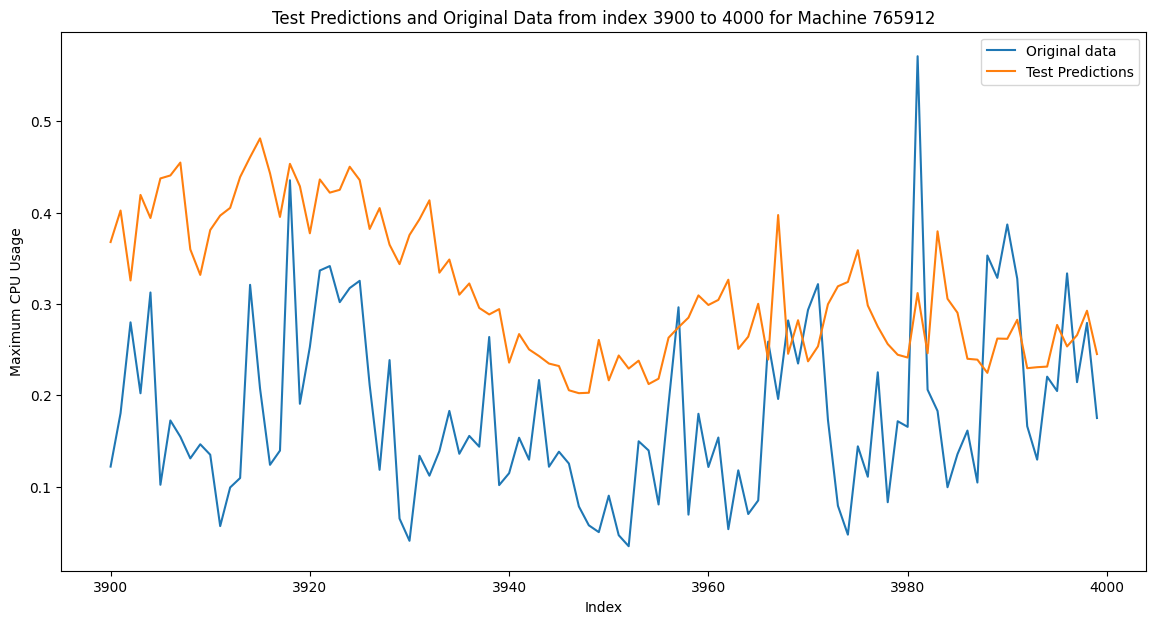

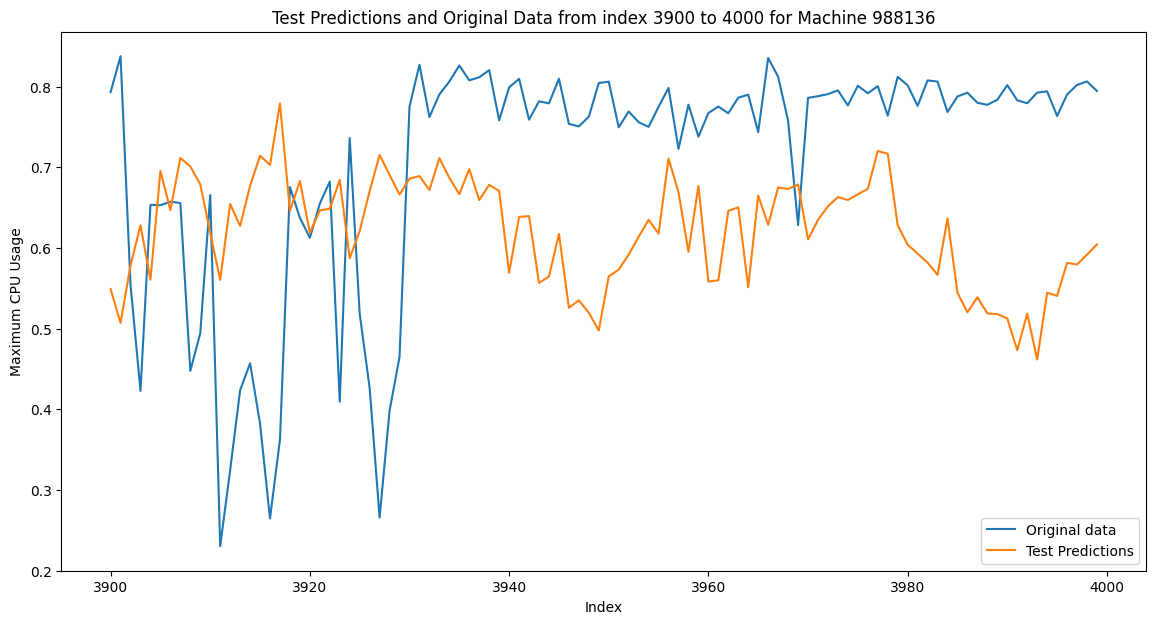

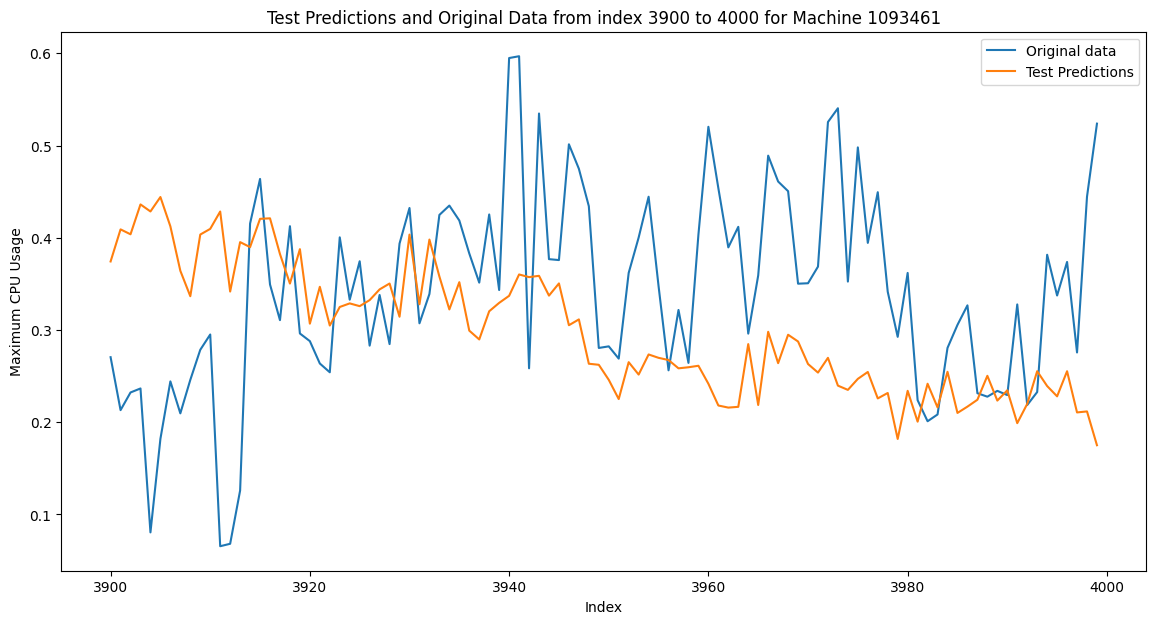

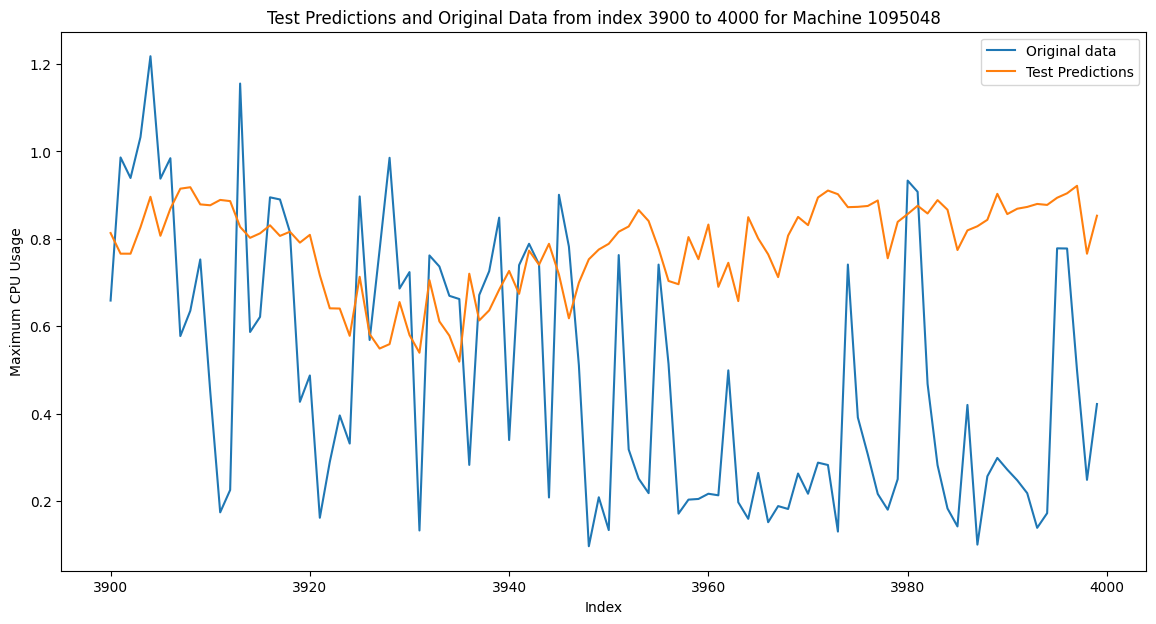

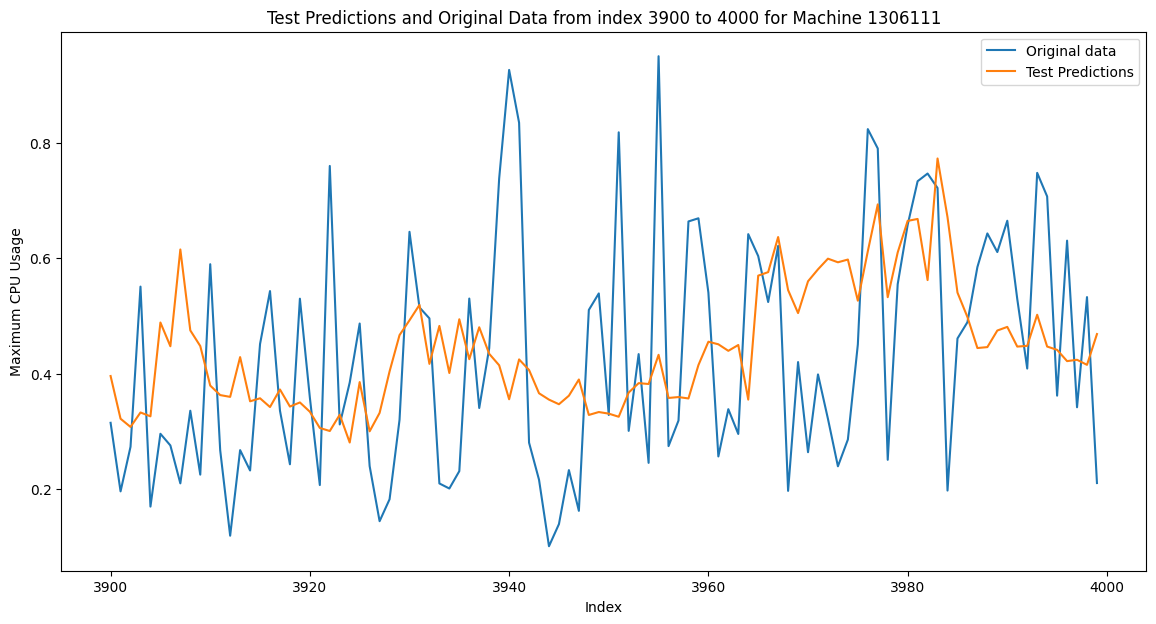

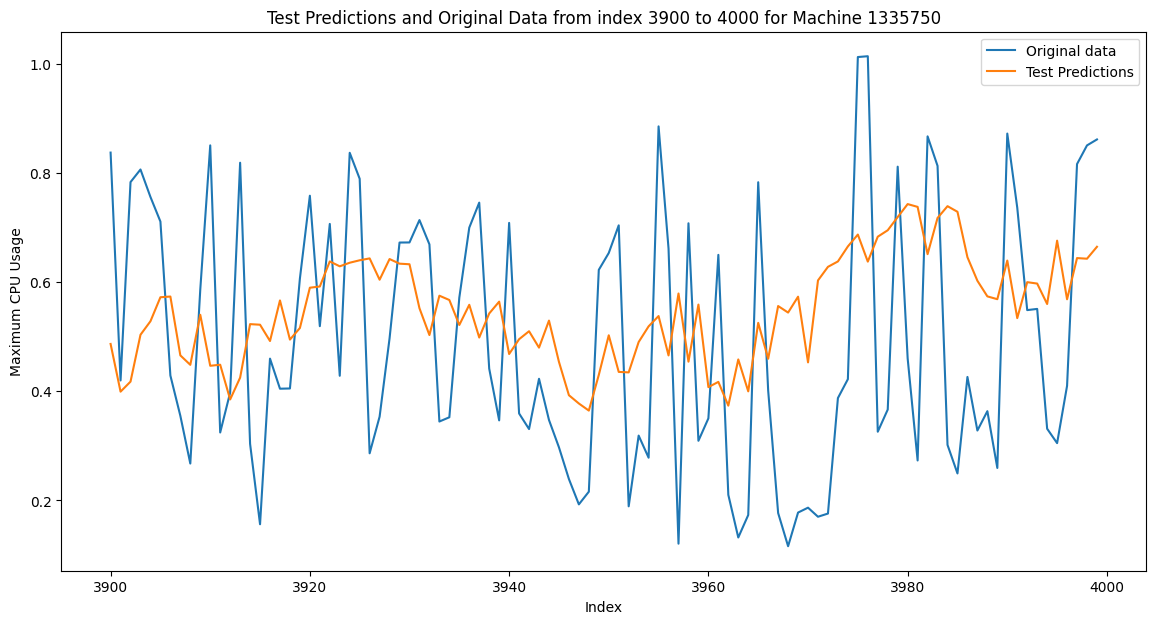

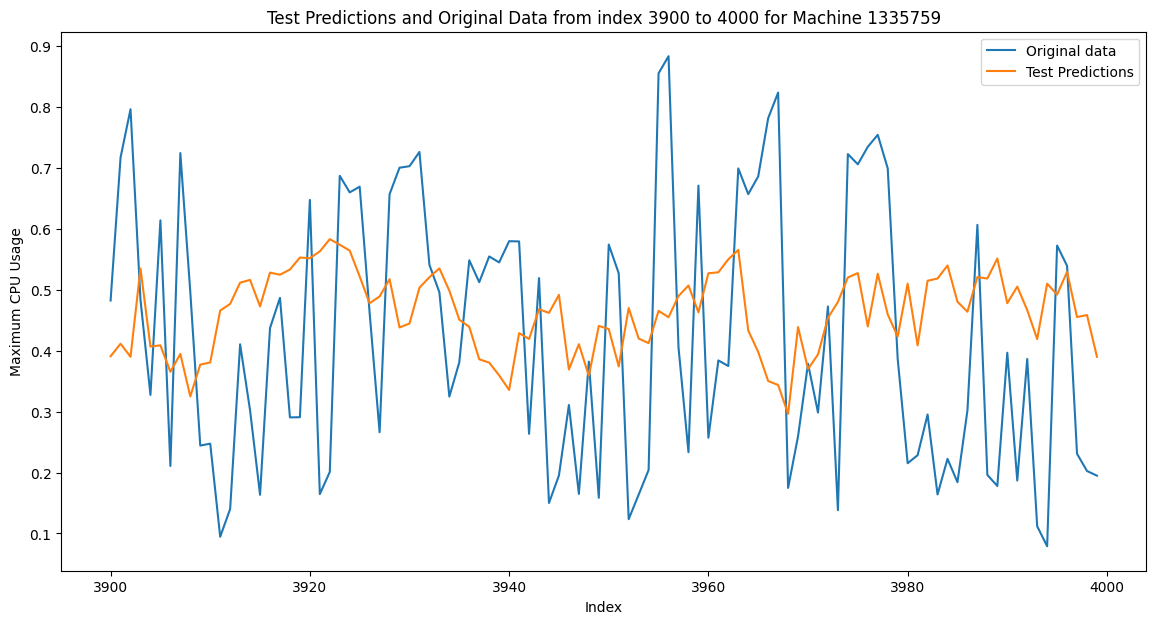

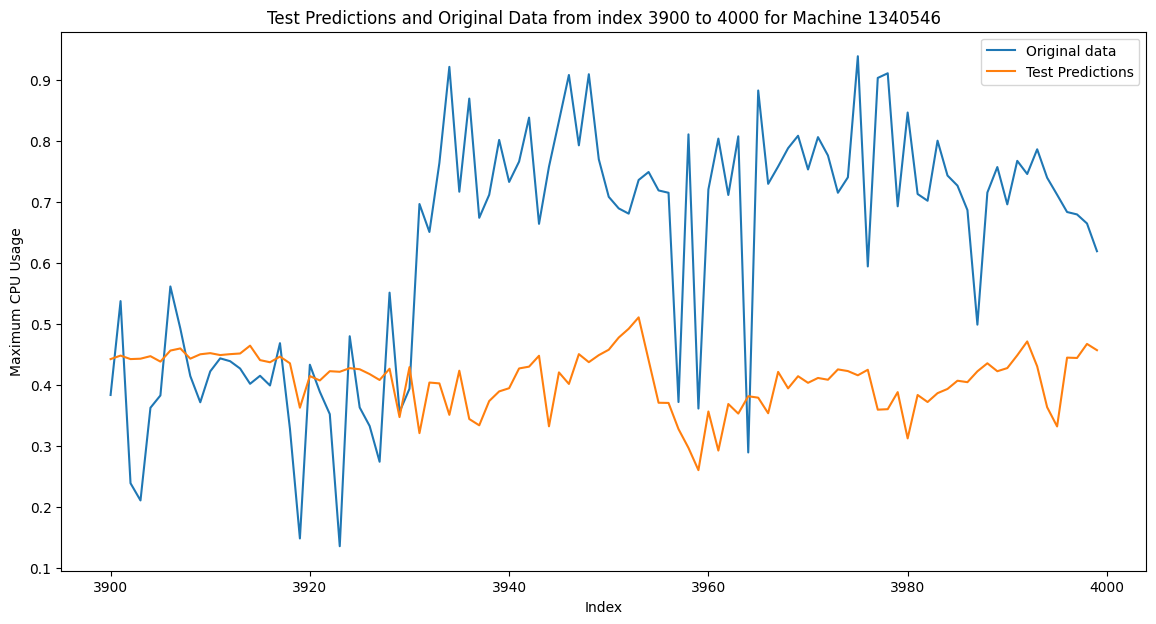

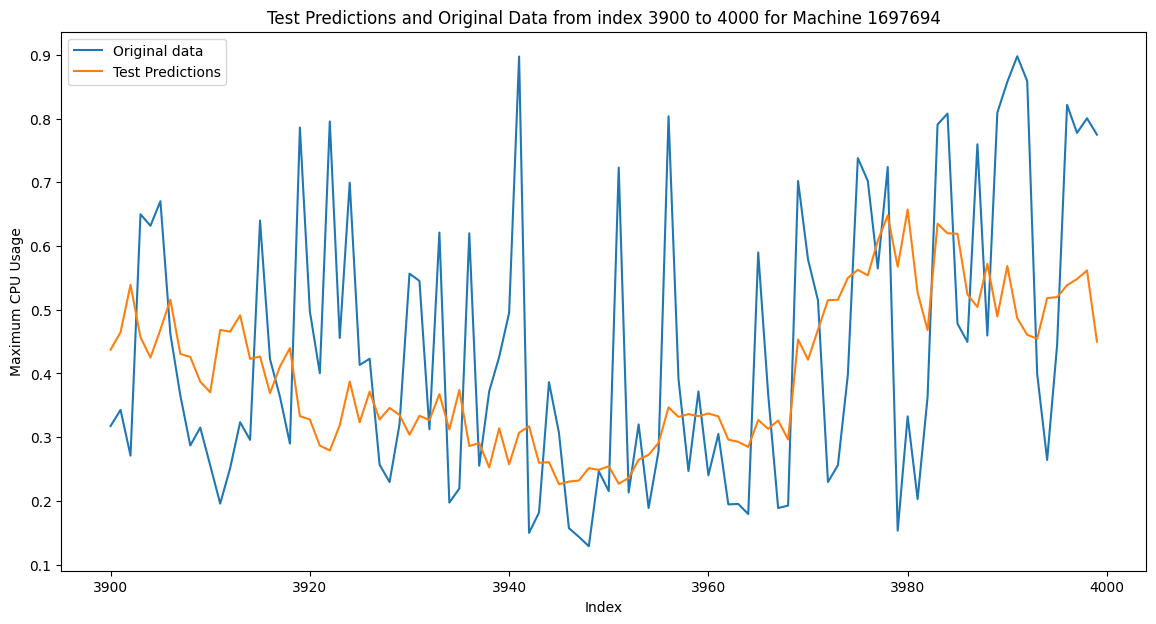

In [20]:
# Define the range of interest    
start_index = 3900    
end_index = 4000    
  
for machine_id in machines:  
    # Create empty arrays of NaNs  
    train_predictions = np.empty_like(train_data[machine_id])  
    train_predictions[:] = np.nan  
    test_predictions = np.empty_like(test_data[machine_id])  
    test_predictions[:] = np.nan  
  
    # Generate predictions  
    lstm.eval()  
    with torch.no_grad():    
        for i, (seq, labels) in enumerate(train_inout_seq[machine_id]):    
            seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)    
            train_pred = lstm(seq)    
            train_predictions[i+seq_length_in : i+seq_length_in+seq_length_out] = train_pred.cpu().numpy().flatten()    
  
        for i, (seq, labels) in enumerate(test_inout_seq[machine_id]):    
            seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)    
            test_pred = lstm(seq)    
            test_predictions[i+seq_length_in : i+seq_length_in+seq_length_out] = test_pred.cpu().numpy().flatten()    
  
    train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))    
    test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))    
    data = scaler.inverse_transform(np.concatenate((train_data[machine_id], test_data[machine_id])).reshape(-1, 1))    
  
    # Adjust start and end indices for test data  
    test_start_index = start_index - len(train_data[machine_id]) - seq_length_in  
    test_end_index = end_index - len(train_data[machine_id]) - seq_length_in  
  
    if test_start_index < 0 or test_end_index < 0 or test_start_index >= len(test_predictions) or test_end_index > len(test_predictions):  
        print(f"Skipping machine {machine_id} due to out of range test data.")  
        continue  
  
    # Plotting    
    plt.figure(figsize=(14, 7))    
  
    # Original data    
    plt.plot(range(start_index, end_index), data[start_index:end_index], label='Original data')    
  
    # Test predictions    
    plt.plot(range(start_index, end_index), test_predictions[test_start_index:test_end_index], label='Test Predictions')    
  
    plt.title(f'Test Predictions and Original Data from index {start_index} to {end_index} for Machine {machine_id}')    
    plt.xlabel('Index')    
    plt.ylabel('Maximum CPU Usage')    
    plt.legend()    
    plt.show()    
